### Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import time

import warnings
warnings.filterwarnings('ignore')

# Bibliothèques NLP
import nltk
import string
import re
import os
import nltk.corpus

from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('words')
stop = set(stopwords.words('english'))
from wordcloud import WordCloud
from collections import defaultdict
from sklearn.feature_extraction.text import TfidfVectorizer
from transformers import TFBertModel, BertTokenizer
import tensorflow as tf
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer, PorterStemmer
from gensim.models import Word2Vec

from nltk.corpus import words
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import numpy as np
import time



from transformers import AutoTokenizer, TFAutoModel
tokenizer = AutoTokenizer.from_pretrained("t5-base")

from matplotlib.image import imread
from os import listdir
from sklearn import cluster
from sklearn import preprocessing
from sklearn import manifold
from sklearn import metrics
import tensorflow_hub as hub

[nltk_data] Downloading package punkt to /Users/zaccaria/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/zaccaria/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zaccaria/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to /Users/zaccaria/nltk_data...
[nltk_data]   Package words is already up-to-date!


### Fonctions

In [2]:
def split_categories(category, level):
    """
    Fonction qui renvoie la partie de la catégorie correspondant au niveau spécifié.

    Paramètres :
    - category: La catégorie à diviser.
    - level: Le niveau de la catégorie à renvoyer.

    Retourne :
    La partie de la catégorie correspondant au niveau spécifié.
    """
    # Supprime les guillemets et divise la catégorie en utilisant '>>' comme séparateur
    category = category.split('["')[1].split('"]')[0]
    cat = category.split(' >> ')

    # Si la catégorie est plus courte que le niveau spécifié, ajoute des 'None' jusqu'au niveau spécifié
    if len(cat) < 3:
        cat = [cat[0], cat[1], 'None']
        if len(cat) < 2:
            cat = [cat[0], 'None', 'None']

    return cat[level]


In [3]:
def detail_categories(dataframe):
    '''Ajoute les colonnes 'categ_1', 'categ_2', 'categ_3' au DataFrame avec les catégories correspondantes'''
    dataframe['categ_1'] = dataframe['product_category_tree'].apply(lambda x: split_categories(x, 0))
    dataframe['categ_2'] = dataframe['product_category_tree'].apply(lambda x: split_categories(x, 1))
    dataframe['categ_3'] = dataframe['product_category_tree'].apply(lambda x: split_categories(x, 2))
    return dataframe


In [4]:
def process_text(text, min_len_word=3, force_is_alpha=True):

    tokenizer = RegexpTokenizer(r'\w+')
    lemmatizer = WordNetLemmatizer()

    # Convertit le texte en minuscules
    text = str(text).lower()
    raw_tokens_list = tokenizer.tokenize(text)
    cleaned_tokens_list = [w for w in raw_tokens_list if w not in stopwords.words('english')]
    non_rare_tokens = [w for w in cleaned_tokens_list if w not in list_rare_words]
    more_than_N = [w for w in non_rare_tokens if len(w) >= min_len_word]

    if force_is_alpha:
        alpha_tokens = [w for w in more_than_N if w.isalpha()]
    else:
        alpha_tokens = more_than_N

    lemmatized_tokens = [lemmatizer.lemmatize(w) for w in alpha_tokens]

    if eng_words:
        english_tokens = [w for w in lemmatized_tokens if w in eng_words]
    else:
        english_tokens = lemmatized_tokens

    trans_text = ' '.join(english_tokens)

    return trans_text


In [5]:
def ari_red(feat):
    """
    Fonction qui utilise la méthode t-SNE pour réduire la dimensionnalité des données à 2 dimensions,
    puis applique l'algorithme K-means pour regrouper les données réduites en clusters.
    Enfin, calcule ARI pour évaluer la similarité entre les clusters obtenus
    et les vraies catégories.

    Paramètres :
    - feat: Les données à réduire et clusteriser.
    - n_clusters: Le nombre de clusters.

    Retourne :
    Tuple contenant l'Adjusted Rand Index (ARI), les données réduites à 2 dimensions (X_tsne),
    et les labels des clusters obtenus.
    """

    # Enregistre le temps de début de l'exécution
    temps_debut = time.time()

    # nombre de clusters
    n_clust =len(n_clusters)
    
    # Réduction de la dimensionnalité des données à 2 dimensions avec t-SNE
    tsne = manifold.TSNE(n_components=2, init='random', random_state=100)
    X_tsne = tsne.fit_transform(feat)

    # Applique K-means pour former les clusters
    cls = cluster.KMeans(n_clusters=n_clust, n_init=10, random_state=100)
    cls.fit(X_tsne)

    # Calcule l'Adjusted Rand Index (ARI) pour évaluer la similarité entre les clusters obtenus et les vraies catégories
    ARI = metrics.adjusted_rand_score(y_feature, cls.labels_)

    # Calcule le temps d'exécution total de la fonction
    temps_execution = np.round(time.time() - temps_debut, 0)

    # Affiche l'ARI et le temps d'exécution
    print("ARI : ", ARI, "Temps d'exécution : ", temps_execution)

    return ARI, X_tsne, cls.labels_


In [6]:
def ari_red_pca(feat):
    """
    Fonction qui utilise TruncatedSVD pour réduire la dimensionnalité des données creuses,
    puis applique t-SNE et K-means.
    Enfin, calcule l'Adjusted Rand Index (ARI) pour évaluer la similarité entre les clusters obtenus
    et les vraies catégories.

    Paramètres :
    - feat: Les données à réduire et clusteriser.
    - y_feature: Les vraies catégories.

    Retourne :
    Tuple contenant l'Adjusted Rand Index (ARI), les données réduites à 2 dimensions (X_tsne),
    et les labels des clusters obtenus.
    """

    # Enregistre le temps de début de l'exécution
    temps_debut = time.time()

    # Réduction de la dimensionnalité des données avec TruncatedSVD
    svd = TruncatedSVD(n_components=30)
    X_svd = svd.fit_transform(feat)

    # Réduction de la dimensionnalité des données à 2 dimensions avec t-SNE
    tsne = manifold.TSNE(n_components=2, init='random', random_state=100)
    X_tsne = tsne.fit_transform(X_svd)

    # Applique K-means pour former les clusters
    cls = cluster.KMeans(n_clusters=len(np.unique(y_feature)), n_init=10, random_state=100)
    cls.fit(X_tsne)

    # Calcule l'Adjusted Rand Index (ARI) pour évaluer la similarité entre les clusters obtenus et les vraies catégories
    ARI = metrics.adjusted_rand_score(y_feature, cls.labels_)

    # Calcule le temps d'exécution total de la fonction
    temps_execution = np.round(time.time() - temps_debut, 0)

    # Affiche l'ARI et le temps d'exécution
    print("ARI : ", ARI, "Temps d'exécution : ", temps_execution)

    return ARI, X_tsne, cls.labels_


In [7]:
def plot_model(X, y_true, labels):
    """
    Affiche deux sous-graphiques pour comparer les catégories réelles avec les clusters prédits.

    Paramètres :
    - X (array-like) : Les données réduites à deux dimensions (résultat de la réduction de dimensionnalité).
    - y_true (array-like) : Les vraies catégories.
    - labels (array-like) : Les clusters prédits.
    """

    # Création de la figure avec deux sous-graphiques
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 9))

    # Premier graphique : Catégories réelles
    scatter1 = ax1.scatter(X[:, 0], X[:, 1], c=y_true)
    ax1.legend(handles=scatter1.legend_elements()[0], labels=n_clusters, loc="best", title="Categories")
    ax1.set_title('Real Categories')

    # Deuxième graphique : Clusters prédits
    scatter2 = ax2.scatter(X[:, 0], X[:, 1], c=labels)
    ax2.legend(*scatter2.legend_elements(), loc="best", title="Clusters")
    ax2.set_title('Clusters')

    # Ajustement de la disposition pour éviter que les graphiques ne se chevauchent
    plt.tight_layout()

    # Affichage des graphiques
    plt.show()


In [8]:
def extract_bert_features(texts):
    """
    Extrait les caractéristiques BERT à partir d'une liste de textes.

    Parameters:
    - texts (list): Liste de textes à traiter.
    """

    # Chargement du modèle BERT pré-entraîné et du tokenizer
    model = TFBertModel.from_pretrained('bert-base-uncased', from_pt=True)
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

    # Définition d'une fonction pour extraire les caractéristiques
    def extract_features(text):
        # Tokenisation du texte et création des tensors d'entrée
        inputs = tokenizer(text, return_tensors="tf", truncation=True, max_length=512)
        # Utilisation des embeddings agrégés pour le clustering
        with tf.device('/CPU:0'):
            outputs = model(**inputs)
        pooled_embeddings = outputs['pooler_output'].numpy()
        return pooled_embeddings

    # Application de la fonction à la liste de textes
    features_list = []
    start_time = time.time()
    for text in texts:
        features = extract_features(text)
        features_list.append(features)
    end_time = time.time()

    # Empilement des caractéristiques le long du premier axe pour obtenir un tableau 2D
    X_feature = np.vstack(features_list)

    # Calcul du temps d'exécution total
    total_time = np.round(end_time - start_time, 2)
    print(f"Temps d'exécution total : {total_time} secondes")

    return X_feature



In [9]:
def feature_USE_fct(sentences, b_size):
    """Cette fonction utilise un modèle Universal Sentence Encoder (USE)
    pour extraire des caractéristiques à partir des phrases données.

    Args:
        sentences (list): Liste de phrases à traiter.
        b_size (int): Taille du lot (batch size) pour le traitement.
    """
    batch_size = b_size
    time3 = time.time()

    for step in range(len(sentences)//batch_size):
        idx = step*batch_size
        feat = use_model(sentences[idx:idx+batch_size])

        if step == 0:
            features = feat
        else:
            features = np.concatenate((features, feat))

    time2 = np.round(time.time() - time3, 0)
    return features


In [10]:
def test_img(methode, n_img):
    """Cette fonction teste la détection de points clés et le calcul des descripteurs
    sur une image en utilisant la méthode spécifiée (SIFT ou ORB).

    Args:
        methode (str): La méthode à utiliser, soit 'sift' pour SIFT, soit 'orb' pour ORB.
        n_img (int): L'indice de l'image à traiter à partir du jeu de données.
    """
    # Initialiser le détecteur
    detector = None

    # Création du détecteur SIFT ou ORB
    if methode == 'sift':
        detector = cv2.SIFT_create()
    elif methode == 'orb':
        detector = cv2.ORB_create()

    # Chargement d'une image
    chemin_image = data_image.image[n_img]
    image = cv2.imread(chemin_image, 0)

    # Égalisation de l'histogramme de l'image
    image = cv2.equalizeHist(image)

    # Détection et calcul des points clés et des descripteurs
    kp, des = detector.detectAndCompute(image, None)

    # Dessiner les points clés sur l'image
    img_avec_points_cles = cv2.drawKeypoints(image, kp, None)

    # Afficher l'image avec les points clés
    plt.figure(figsize=(10, 10))
    plt.imshow(img_avec_points_cles)
    plt.show()

    # Afficher le nombre de descripteurs
    print("Le nombre des features extraits est de : ", des.shape)


In [11]:
def generate_wordclouds(df, category_column):
    """
    Générer des nuages de mots pour chaque catégorie unique dans le DataFrame.

    Parameters:
    - df: Le DataFrame contenant les données.
    - category_column: Le nom de la colonne contenant les catégories.

    """

    # Obtenir les catégories uniques de la colonne spécifiée
    unique_categories = df[category_column].unique()

    # Calculer le nombre de lignes et de colonnes en fonction du nombre de catégories uniques
    num_categories = len(unique_categories)
    num_cols = 3  # Nombre de colonnes dans la disposition en sous-graphiques
    num_rows = (num_categories - 1) // num_cols + 1  # Calculer une rangée supplémentaire pour les catégories restantes

    # Créer les sous-graphiques
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 10), constrained_layout=True)

    # Aplatir le tableau axs
    axs = axs.flatten()

    # Créer un nuage de mots pour chaque catégorie
    for i, category in enumerate(unique_categories):
        # Filtrer le DataFrame pour la catégorie actuelle
        df_category = df[df[category_column] == category]

        # Concaténer tous les mots de la colonne "clean_text" pour la catégorie actuelle
        text = ' '.join(df_category['clean_text'].str.lower())

        # Créer un objet WordCloud
        wordcloud = WordCloud(width=400, height=400,
                              background_color='white',
                              min_font_size=10).generate(text)

        # Afficher le nuage de mots sur le sous-graphique correspondant
        axs[i].imshow(wordcloud)
        axs[i].axis("off")
        axs[i].set_title(f"Catégorie : {category}")

    # Supprimer les sous-graphiques vides restants
    for j in range(num_categories, num_rows * num_cols):
        fig.delaxes(axs[j])

    # Afficher les sous-graphiques
    plt.show()


### DF

In [12]:
# import df
df = pd.read_csv('../data/raw/data.csv')

In [13]:
# affichage sample df
display(df.sample(5))

uniq_id            crawl_timestamp  \
71   f2658bad8c2b7d5b08984c6ac34267f7  2016-04-19 05:00:32 +0000   
430  a54b94096938252901d3f7f8de97bffb  2016-03-11 06:55:07 +0000   
306  7e11aaffb1d08f8091ea94598f7865aa  2015-12-01 06:13:00 +0000   
809  1d1be744e491ed61e705c20e4a72320d  2015-12-12 11:46:53 +0000   
225  67d6b4a8aa19d57740b0440365b77624  2015-12-01 12:40:44 +0000   

                                           product_url  \
71   http://www.flipkart.com/prime-printed-8-seater...   
430  http://www.flipkart.com/ocean-vglass0051/p/itm...   
306  http://www.flipkart.com/lal-haveli-rajasthani-...   
809  http://www.flipkart.com/oxyglow-lacto-bleach-f...   
225  http://www.flipkart.com/lal-haveli-decorative-...   

                                          product_name  \
71                  Prime Printed 8 Seater Table Cover   
430                                   ocean VGLASS0051   
306  Lal Haveli Rajasthani Handmade Decorative Wood...   
809  Oxyglow Lacto Bleach & Fruit Massage Cream Wit...   
225  Lal Haveli Decorative Dholak Musician Showpiec...   

                                 product_category_tree               pid  \
71   ["Home Furnishing >> Kitchen & Dining Linen >>...  TCVEHSMFYEQGRTAZ   
430  ["Kitchen & Dining >> Bar & Glassware >> Bar G...  GLSEGP36GJQSARZS   
306  ["Home Decor & Festive Needs >> Showpieces >> ...  SHIE9J6PFKPDMEGK   
809  ["Beauty and Personal Care >> Combos and Kits ...  CBKEA9HYUXZEYXAH   
225  ["Home Decor & Festive Needs >> Showpieces >> ...  SHIEBCQZF8EQ3FSD   

     retail_price  discounted_price                                 image  \
71         2000.0             899.0  f2658bad8c2b7d5b08984c6ac34267f7.jpg   
430        1600.0            1145.0  a54b94096938252901d3f7f8de97bffb.jpg   
306        1000.0             749.0  7e11aaffb1d08f8091ea94598f7865aa.jpg   
809         990.0             594.0  1d1be744e491ed61e705c20e4a72320d.jpg   
225        1450.0            1085.0  67d6b4a8aa19d57740b0440365b77624.jpg   

     is_FK_Advantage_product  \
71                     False   
430                    False   
306                    False   
809                    False   
225                    False   

                                           description       product_rating  \
71   Key Features of Prime Printed 8 Seater Table C...                    5   
430  Key Features of ocean VGLASS0051 pack of 6,oce...  No rating available   
306  Buy Lal Haveli Rajasthani Handmade Decorative ...  No rating available   
809  Oxyglow Lacto Bleach & Fruit Massage Cream Wit...  No rating available   
225  Lal Haveli Decorative Dholak Musician Showpiec...  No rating available   

          overall_rating       brand  \
71                     5       Prime   
430  No rating available       ocean   
306  No rating available  Lal Haveli   
809  No rating available         NaN   
225  No rating available  Lal Haveli   

                                product_specifications  
71   {"product_specification"=>[{"key"=>"Number of ...  
430  {"product_specification"=>[{"key"=>"Brand", "v...  
306  {"product_specification"=>[{"key"=>"Brand", "v...  
809  {"product_specification"=>[{"key"=>"Organic Ty...  
225  {"product_specification"=>[{"key"=>"Brand", "v...

In [14]:
# dimensions df
print(f'le df est composée par {df.shape[0]} lignes et {df.shape[1]} colonnes')

le df est composée par 1050 lignes et 15 colonnes


<Axes: >

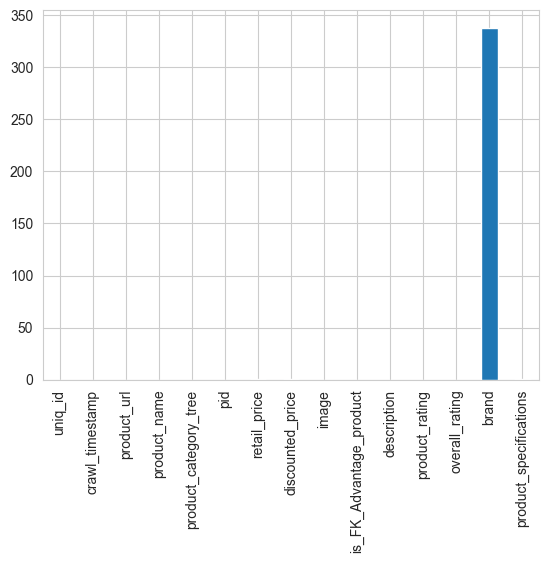

In [15]:
# controle valeurs nulles
df.isna().sum().plot(kind='bar')

### Analyses générales

In [16]:
# nombre colonne product_category_tree
df['product_category_tree'].nunique()

642

In [17]:
# Affichage categories
display(df['product_category_tree'].value_counts().head(5))

product_category_tree
["Home Furnishing >> Bed Linen >> Blankets, Quilts & Dohars"]    56
["Kitchen & Dining >> Coffee Mugs >> Prithish Coffee Mugs"]      26
["Watches >> Wrist Watches >> Maxima Wrist Watches"]             23
["Kitchen & Dining >> Coffee Mugs >> Rockmantra Coffee Mugs"]    22
["Home Furnishing >> Bath Linen >> Towels"]                      19
Name: count, dtype: int64

La colonne ``product_category_tree`` contient les categories des produits sur 3 niveaux differentes

Axes(0.125,0.11;0.775x0.77)


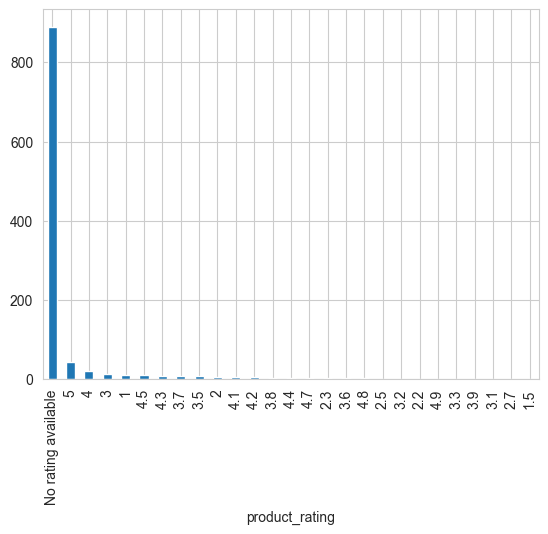

In [18]:
# contrôle notes
print(df['product_rating'].value_counts().plot(kind='bar'))

La majorité des produits n'ont pas une note dans le df

### Analyse catégories

Tout d'abord on vas splitter le catégories pour avoir trois colonnes pour chaque niveaux et puis on vas analyser chaque niveaux

In [19]:
# fonction pour diviser les catégories
df1 = detail_categories(df)

In [20]:
# affichage df
display(df1.head(5))

uniq_id            crawl_timestamp  \
0  55b85ea15a1536d46b7190ad6fff8ce7  2016-04-30 03:22:56 +0000   
1  7b72c92c2f6c40268628ec5f14c6d590  2016-04-30 03:22:56 +0000   
2  64d5d4a258243731dc7bbb1eef49ad74  2016-04-30 03:22:56 +0000   
3  d4684dcdc759dd9cdf41504698d737d8  2016-06-20 08:49:52 +0000   
4  6325b6870c54cd47be6ebfbffa620ec7  2016-06-20 08:49:52 +0000   

                                         product_url  \
0  http://www.flipkart.com/elegance-polyester-mul...   
1  http://www.flipkart.com/sathiyas-cotton-bath-t...   
2  http://www.flipkart.com/eurospa-cotton-terry-f...   
3  http://www.flipkart.com/santosh-royal-fashion-...   
4  http://www.flipkart.com/jaipur-print-cotton-fl...   

                                        product_name  \
0  Elegance Polyester Multicolor Abstract Eyelet ...   
1                         Sathiyas Cotton Bath Towel   
2                Eurospa Cotton Terry Face Towel Set   
3  SANTOSH ROYAL FASHION Cotton Printed King size...   
4  Jaipur Print Cotton Floral King sized Double B...   

                               product_category_tree               pid  \
0  ["Home Furnishing >> Curtains & Accessories >>...  CRNEG7BKMFFYHQ8Z   
1  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...  BTWEGFZHGBXPHZUH   
2  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...  BTWEG6SHXTDB2A2Y   
3  ["Home Furnishing >> Bed Linen >> Bedsheets >>...  BDSEJT9UQWHDUBH4   
4  ["Home Furnishing >> Bed Linen >> Bedsheets >>...  BDSEJTHNGWVGWWQU   

   retail_price  discounted_price                                 image  \
0        1899.0             899.0  55b85ea15a1536d46b7190ad6fff8ce7.jpg   
1         600.0             449.0  7b72c92c2f6c40268628ec5f14c6d590.jpg   
2           NaN               NaN  64d5d4a258243731dc7bbb1eef49ad74.jpg   
3        2699.0            1299.0  d4684dcdc759dd9cdf41504698d737d8.jpg   
4        2599.0             698.0  6325b6870c54cd47be6ebfbffa620ec7.jpg   

   is_FK_Advantage_product                                        description  \
0                    False  Key Features of Elegance Polyester Multicolor ...   
1                    False  Specifications of Sathiyas Cotton Bath Towel (...   
2                    False  Key Features of Eurospa Cotton Terry Face Towe...   
3                    False  Key Features of SANTOSH ROYAL FASHION Cotton P...   
4                    False  Key Features of Jaipur Print Cotton Floral Kin...   

        product_rating       overall_rating                  brand  \
0  No rating available  No rating available               Elegance   
1  No rating available  No rating available               Sathiyas   
2  No rating available  No rating available                Eurospa   
3  No rating available  No rating available  SANTOSH ROYAL FASHION   
4  No rating available  No rating available           Jaipur Print   

                              product_specifications          categ_1  \
0  {"product_specification"=>[{"key"=>"Brand", "v...  Home Furnishing   
1  {"product_specification"=>[{"key"=>"Machine Wa...        Baby Care   
2  {"product_specification"=>[{"key"=>"Material",...        Baby Care   
3  {"product_specification"=>[{"key"=>"Brand", "v...  Home Furnishing   
4  {"product_specification"=>[{"key"=>"Machine Wa...  Home Furnishing   

                  categ_2           categ_3  
0  Curtains & Accessories          Curtains  
1        Baby Bath & Skin  Baby Bath Towels  
2        Baby Bath & Skin  Baby Bath Towels  
3               Bed Linen         Bedsheets  
4               Bed Linen         Bedsheets

#### Analyse Catégories

Il y a 7 catégories uniques dans le niveau 1.


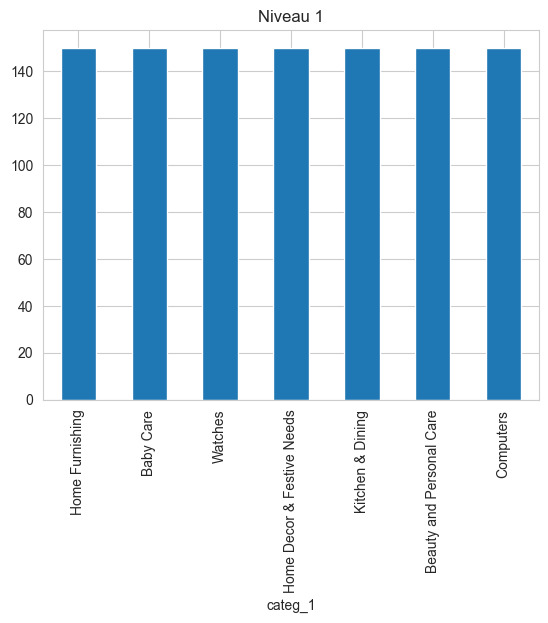

Il y a 62 catégories uniques dans le niveau 2.


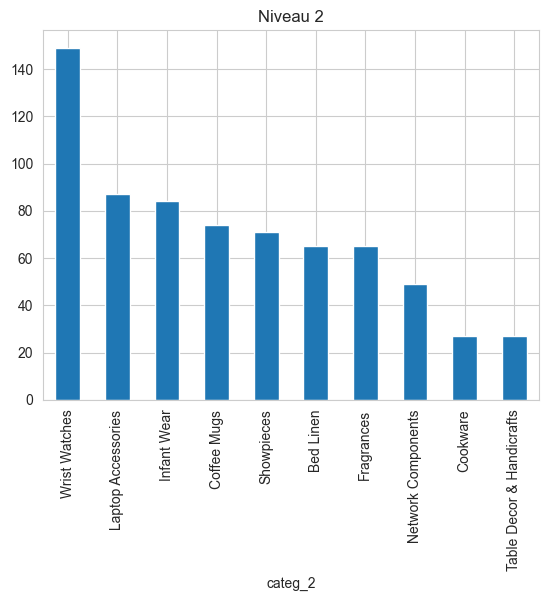

Il y a 242 catégories uniques dans le niveau 3.


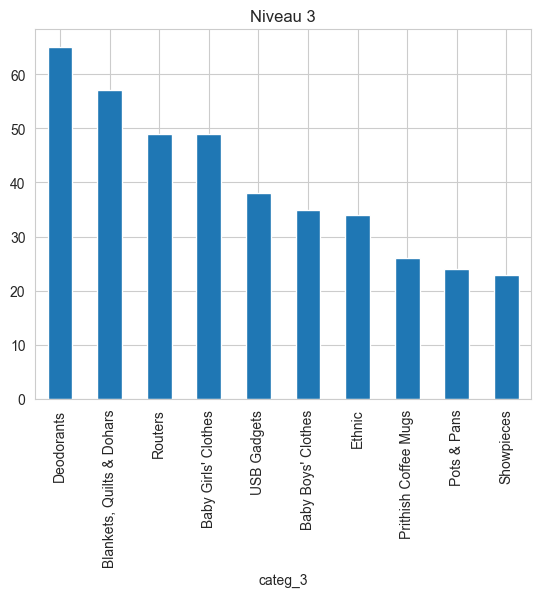

In [21]:
# Définition des niveaux de catégories
levels = [1, 2, 3]

# Boucle pour chaque niveau de catégorie
for level in levels:
    # Calcul du nombre de catégories uniques
    unique_categories = df1[f'categ_{level}'].nunique()
    # Impression du nombre de catégories uniques dans ce niveau
    print(f"Il y a {unique_categories} catégories uniques dans le niveau {level}.")
    # Sélection des 10 principales catégories
    top_10_categories = df1[f'categ_{level}'].value_counts().nlargest(10)
    # Plot des 10 principales catégories
    top_10_categories.plot(kind='bar')
    plt.title(f"Niveau {level}")
    plt.show()

Les catégories du ``niveau 1`` sont bien réparties, on voit qu'il y a 7 catégories uniques et qu'elles ont la même taille.
Plus on descend dans les niveaux, plus les catégories augmentent et la différence de taille entre chaque catégorie a tendance à varier beaucoup.
Dans le ``niveau 2``, les catégories les plus présentes sont les horloges, puis les accessoires pour les PC, et enfin les produits pour enfants.
Dans le ``niveau 3``, on peut aussi observer les produits singuliers qui sont plus présents dans le fichier, notamment des déodorants, des produits pour la salle de bain, et des routeurs.


### Comptage données textuelles

Les données qui nous interessent sont contenus dans la colonne ``description``

In [22]:
# affichage description
display(df1[['description']].head(5))

description
0  Key Features of Elegance Polyester Multicolor ...
1  Specifications of Sathiyas Cotton Bath Towel (...
2  Key Features of Eurospa Cotton Terry Face Towe...
3  Key Features of SANTOSH ROYAL FASHION Cotton P...
4  Key Features of Jaipur Print Cotton Floral Kin...

On va créer une colonne avec la longueur en caracteres et des mots contenu dans la colonne ``description``

In [23]:
# Comptage du nombre de mots dans la description
df1['text_len'] = df1['description'].apply(lambda x: len(x.split()))

In [24]:
# Fonction pour compter le nombre de caractères dans un texte
def char_count(text):
    return sum(len(word) for word in text.split())

In [25]:
# Comptage du nombre de caractères dans la description
df1['text_char_len'] = df1['description'].apply(char_count)

In [26]:
# Affichage des nouvelles colonnes
display(df1[['description','text_len','text_char_len']].head(10))

description  text_len  text_char_len
0  Key Features of Elegance Polyester Multicolor ...       230           1191
1  Specifications of Sathiyas Cotton Bath Towel (...        74            371
2  Key Features of Eurospa Cotton Terry Face Towe...       215           1044
3  Key Features of SANTOSH ROYAL FASHION Cotton P...       145            714
4  Key Features of Jaipur Print Cotton Floral Kin...       214            984
5  Maserati Time R8851116001 Analog Watch  - For ...        42            231
6  Camerii WM64 Elegance Analog Watch  - For Men,...        44            222
7  T STAR UFT-TSW-005-BK-BR Analog Watch  - For B...       131            649
8  Alfajr WY16B Youth Digital Watch  - For Men, B...        66            342
9  TAG Heuer CAU1116.BA0858 Formula 1 Analog Watc...        63            365

#### Traitement text

In [27]:
dict=defaultdict(int)
# création list avec corpus 
corpus=[]
# boucle pour ajouter les description dans la liste
for x in df1['description'].str.split():
    for i in x:
        corpus.append(i)
# Concaténer tous les mots dans le corpus
text = ' '.join(corpus)

In [28]:
# Itération à travers le corpus pour compter les occurrences de chaque mot stop
for word in corpus:
    if word not in stop:
        dict[word] += 1

# Sélection des 30 mots stop les plus fréquents
top = sorted(dict.items(), key=lambda x: x[1], reverse=True)[:30]

# Séparation des clés et des valeurs
x, y = zip(*top)

# Création du graphique à barres avec Plotly Express
fig = px.bar(x=x, y=y)

# Mise à jour du layout du graphique avec un titre et des titres d'axes
fig.update_layout(
    title="Mots communs les plus utilisés",
    xaxis_title='Mots',
    yaxis_title='Fréquence'
)

### Nettoyage du texte

In [29]:
# définition dictionnaire anglais
eng_words = [i.lower() for i in words.words()]

In [30]:
# définition paroles rares
tmp = pd.Series(text).value_counts()
list_rare_words = tmp[tmp==1]

In [31]:
# nettoyage du texte et affichage table
df1['clean_text'] = df1['description'].apply(process_text)
display(df1.head())

uniq_id            crawl_timestamp  \
0  55b85ea15a1536d46b7190ad6fff8ce7  2016-04-30 03:22:56 +0000   
1  7b72c92c2f6c40268628ec5f14c6d590  2016-04-30 03:22:56 +0000   
2  64d5d4a258243731dc7bbb1eef49ad74  2016-04-30 03:22:56 +0000   
3  d4684dcdc759dd9cdf41504698d737d8  2016-06-20 08:49:52 +0000   
4  6325b6870c54cd47be6ebfbffa620ec7  2016-06-20 08:49:52 +0000   

                                         product_url  \
0  http://www.flipkart.com/elegance-polyester-mul...   
1  http://www.flipkart.com/sathiyas-cotton-bath-t...   
2  http://www.flipkart.com/eurospa-cotton-terry-f...   
3  http://www.flipkart.com/santosh-royal-fashion-...   
4  http://www.flipkart.com/jaipur-print-cotton-fl...   

                                        product_name  \
0  Elegance Polyester Multicolor Abstract Eyelet ...   
1                         Sathiyas Cotton Bath Towel   
2                Eurospa Cotton Terry Face Towel Set   
3  SANTOSH ROYAL FASHION Cotton Printed King size...   
4  Jaipur Print Cotton Floral King sized Double B...   

                               product_category_tree               pid  \
0  ["Home Furnishing >> Curtains & Accessories >>...  CRNEG7BKMFFYHQ8Z   
1  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...  BTWEGFZHGBXPHZUH   
2  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...  BTWEG6SHXTDB2A2Y   
3  ["Home Furnishing >> Bed Linen >> Bedsheets >>...  BDSEJT9UQWHDUBH4   
4  ["Home Furnishing >> Bed Linen >> Bedsheets >>...  BDSEJTHNGWVGWWQU   

   retail_price  discounted_price                                 image  \
0        1899.0             899.0  55b85ea15a1536d46b7190ad6fff8ce7.jpg   
1         600.0             449.0  7b72c92c2f6c40268628ec5f14c6d590.jpg   
2           NaN               NaN  64d5d4a258243731dc7bbb1eef49ad74.jpg   
3        2699.0            1299.0  d4684dcdc759dd9cdf41504698d737d8.jpg   
4        2599.0             698.0  6325b6870c54cd47be6ebfbffa620ec7.jpg   

   is_FK_Advantage_product  ...       product_rating       overall_rating  \
0                    False  ...  No rating available  No rating available   
1                    False  ...  No rating available  No rating available   
2                    False  ...  No rating available  No rating available   
3                    False  ...  No rating available  No rating available   
4                    False  ...  No rating available  No rating available   

                   brand                             product_specifications  \
0               Elegance  {"product_specification"=>[{"key"=>"Brand", "v...   
1               Sathiyas  {"product_specification"=>[{"key"=>"Machine Wa...   
2                Eurospa  {"product_specification"=>[{"key"=>"Material",...   
3  SANTOSH ROYAL FASHION  {"product_specification"=>[{"key"=>"Brand", "v...   
4           Jaipur Print  {"product_specification"=>[{"key"=>"Machine Wa...   

           categ_1                 categ_2           categ_3 text_len  \
0  Home Furnishing  Curtains & Accessories          Curtains      230   
1        Baby Care        Baby Bath & Skin  Baby Bath Towels       74   
2        Baby Care        Baby Bath & Skin  Baby Bath Towels      215   
3  Home Furnishing               Bed Linen         Bedsheets      145   
4  Home Furnishing               Bed Linen         Bedsheets      214   

   text_char_len                                         clean_text  
0           1191  key feature elegance polyester multicolor abst...  
1            371  specification cotton bath towel bath towel red...  
2           1044  key feature cotton terry face towel set size s...  
3            714  key feature royal fashion cotton printed king ...  
4            984  key feature print cotton floral king sized dou...  

[5 rows x 21 columns]

In [32]:
# Création barplot pour les mots plus utilisées après traitement
corpus=[]

for x in df1['clean_text'].str.split():
    for i in x:
        corpus.append(i)

for word in corpus:
    if word not in stop:
        dict[word]+=1

top=sorted(dict.items(), key=lambda x:x[1],reverse=True)[:30]
x,y=zip(*top)
fig=px.bar(x=x,y=y)
fig.update_layout(title={
    'text': "Mots les plus utilisés",
    'y':0.95,
    'x':0.5,
    'xanchor': 'center',
    'yanchor': 'top'},xaxis_title='Mots utilisés',yaxis_title='Frequency')

### Comparaison longueur charactères et numéro mots avant et après traitement

In [33]:
# Comptage des mots
df1['text_len_clean'] = df1['clean_text'].apply(lambda x: len(x.split()))
# Comptage du nombre de caractères
df1['text_char_len_clean'] = df1['clean_text'].apply(char_count)

In [34]:
# Affichage des nouvelles colonnes
display(df1[['description','clean_text','text_len','text_len_clean','text_char_len','text_char_len_clean']].sample(10))

description  \
305   Buy Pg handicrafts Beaded two drawers sofa set...   
245   Buy Kalash Kadhai 11.5 L for Rs.1584 online. K...   
563   Fluid FS201-BL01 Analog-Digital Watch  - For W...   
126   Flipkart.com: Buy Svayam Premium Manicure Duo ...   
514   Maxima 04615CMGY Gold Analog Watch  - For Men ...   
59    Specifications of Brillare Science Dandruff Co...   
682   Flipkart.com: Buy VLCC Natural Sciences Oil Fr...   
1039  Key Features of Reiki Crystal Products Showpie...   
497   Times 284TMS284 Party-Wedding Analog Watch  - ...   
69    Specifications of GAYATRI CREATIONS ORANGE KID...   

                                             clean_text  text_len  \
305   buy handicraft beaded two drawer sofa set show...        45   
245   buy best price free shipping cash delivery gen...        29   
563   fluid digital watch woman buy fluid digital wa...        46   
126   buy premium manicure duo stainless steel price...        29   
514   maximum gold watch men buy maximum gold watch ...        50   
59    specification science dandruff control shampoo...        41   
682   buy natural science oil free gel pack price ge...        37   
1039  key feature crystal product showpiece singing ...       270   
497   time party wedding watch woman buy time party ...        42   
69    specification gayatri creation orange set cont...        48   

      text_len_clean  text_char_len  text_char_len_clean  
305               28            231                  173  
245               12            144                   73  
563               27            264                  158  
126               16            169                  101  
514               29            263                  163  
59                24            228                  152  
682               17            188                   97  
1039             140           1336                  877  
497               23            237                  134  
69                33            225                  184

### WordCloud

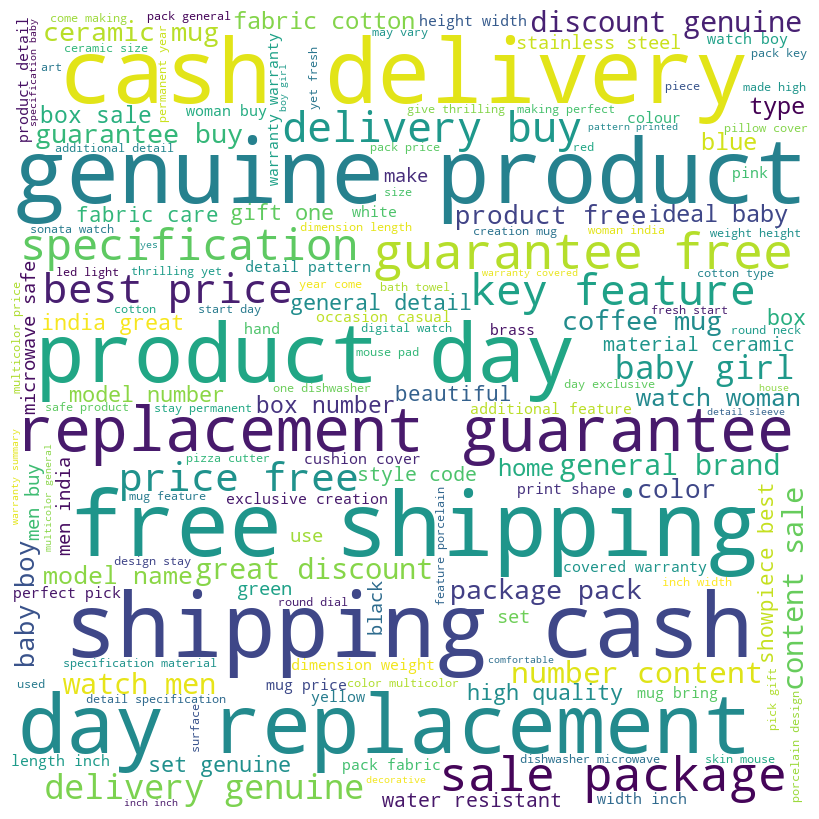

In [35]:
# Concaténer tous les mots dans la colonne "clean_text"
text = ' '.join(df1['clean_text'].str.lower())

# Créer un objet WordCloud
wordcloud = WordCloud(width = 800, height = 800,
                      background_color ='white',
                      min_font_size = 10).generate(text)

# Afficher le WordCloud
plt.figure(figsize = (8, 12), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()

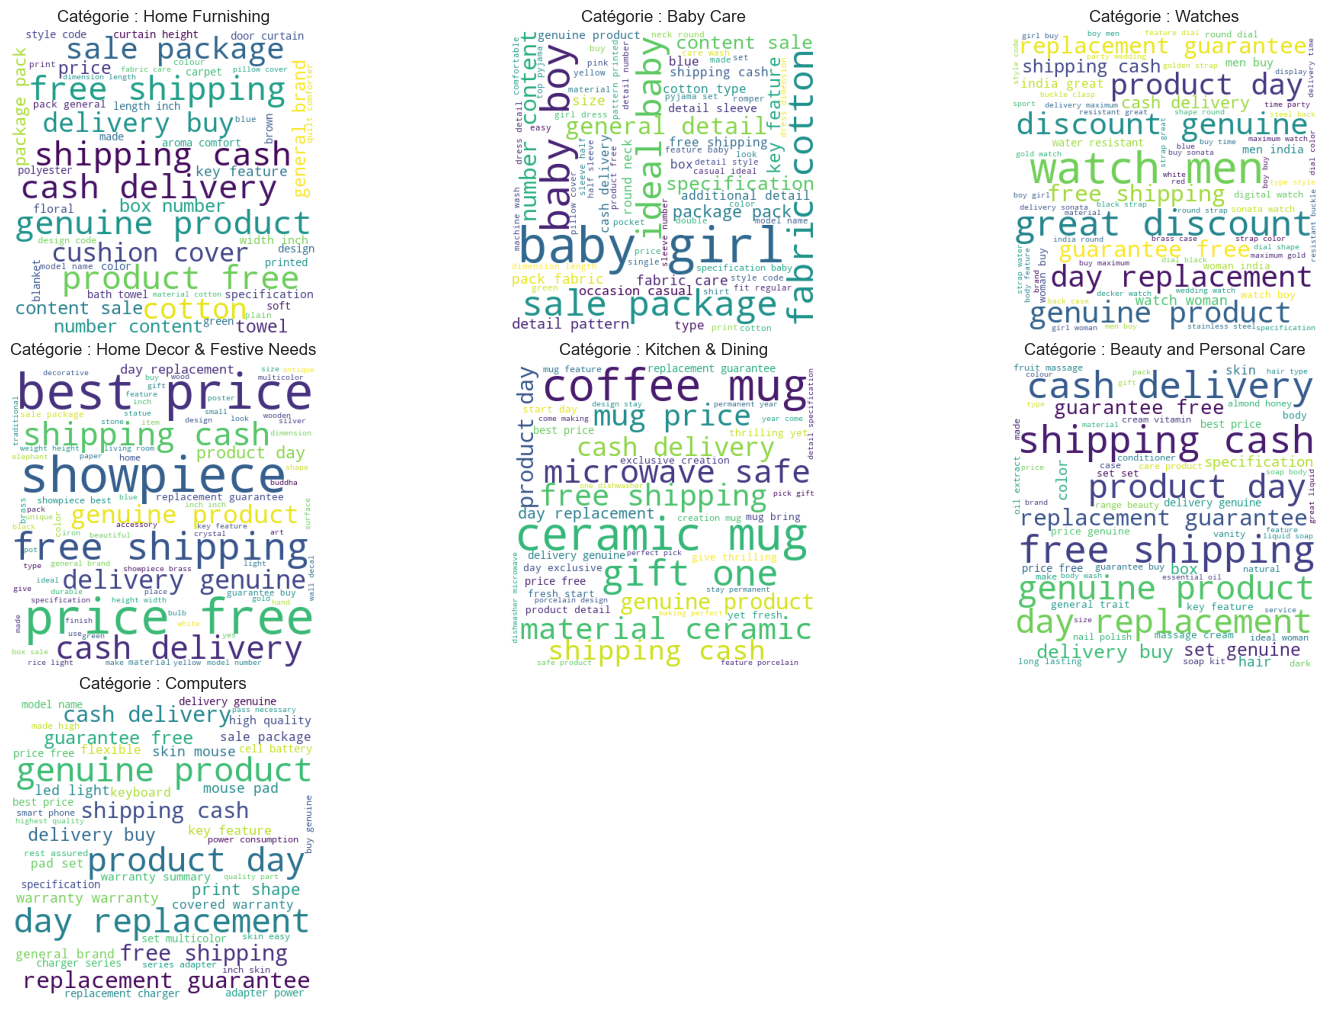

In [36]:
generate_wordclouds(df1, 'categ_1')

### Feature engineering

In [37]:
# Colonnes à supprimer
df2 = df1.copy()
df2.drop(columns = ['uniq_id', 'crawl_timestamp','product_category_tree', 'product_url', 'product_name', 'pid',
                     'retail_price', 'discounted_price','is_FK_Advantage_product', 'product_rating', 'overall_rating',
                     'product_specifications',
                     'text_len', 'text_char_len', 'text_len_clean','brand',
                     'text_char_len_clean'], inplace = True)

In [38]:
# affichage df
display(df2.head(3))

image  \
0  55b85ea15a1536d46b7190ad6fff8ce7.jpg   
1  7b72c92c2f6c40268628ec5f14c6d590.jpg   
2  64d5d4a258243731dc7bbb1eef49ad74.jpg   

                                         description          categ_1  \
0  Key Features of Elegance Polyester Multicolor ...  Home Furnishing   
1  Specifications of Sathiyas Cotton Bath Towel (...        Baby Care   
2  Key Features of Eurospa Cotton Terry Face Towe...        Baby Care   

                  categ_2           categ_3  \
0  Curtains & Accessories          Curtains   
1        Baby Bath & Skin  Baby Bath Towels   
2        Baby Bath & Skin  Baby Bath Towels   

                                          clean_text  
0  key feature elegance polyester multicolor abst...  
1  specification cotton bath towel bath towel red...  
2  key feature cotton terry face towel set size s...

In [39]:
# labelisation catégories
encode = preprocessing.LabelEncoder()
df2['label_categ'] = encode.fit_transform(np.array(df2['categ_1']))

# affichage df
display(df2.head(3))

image  \
0  55b85ea15a1536d46b7190ad6fff8ce7.jpg   
1  7b72c92c2f6c40268628ec5f14c6d590.jpg   
2  64d5d4a258243731dc7bbb1eef49ad74.jpg   

                                         description          categ_1  \
0  Key Features of Elegance Polyester Multicolor ...  Home Furnishing   
1  Specifications of Sathiyas Cotton Bath Towel (...        Baby Care   
2  Key Features of Eurospa Cotton Terry Face Towe...        Baby Care   

                  categ_2           categ_3  \
0  Curtains & Accessories          Curtains   
1        Baby Bath & Skin  Baby Bath Towels   
2        Baby Bath & Skin  Baby Bath Towels   

                                          clean_text  label_categ  
0  key feature elegance polyester multicolor abst...            4  
1  specification cotton bath towel bath towel red...            0  
2  key feature cotton terry face towel set size s...            0

### Méthode TD-IDF
La méthode TF-IDF (Term Frequency-Inverse Document Frequency) est une technique utilisée en traitement automatique du langage naturel et en recherche d'information pour évaluer l'importance d'un terme dans un document au sein d'une collection de documents. Elle prend en compte à la fois la fréquence d'apparition du terme dans le document (TF) et son importance relative dans l'ensemble des documents (IDF). 

In [40]:
# création du nombre de clusters 
n_clusters = list(df2.categ_1.unique())

In [41]:
# création variable pour les features
y_feature = df2['label_categ']

In [42]:
# init méthode td-idf vectorizer
vectorizer = TfidfVectorizer()
feat = 'clean_text'
tf_vectorizer_fit = vectorizer.fit(df2[feat])
tf_vectorizer_transform = vectorizer.transform(df2[feat])

Méthode TD-IDF
ARI :  0.4577140433392419 Temps d'exécution :  3.0


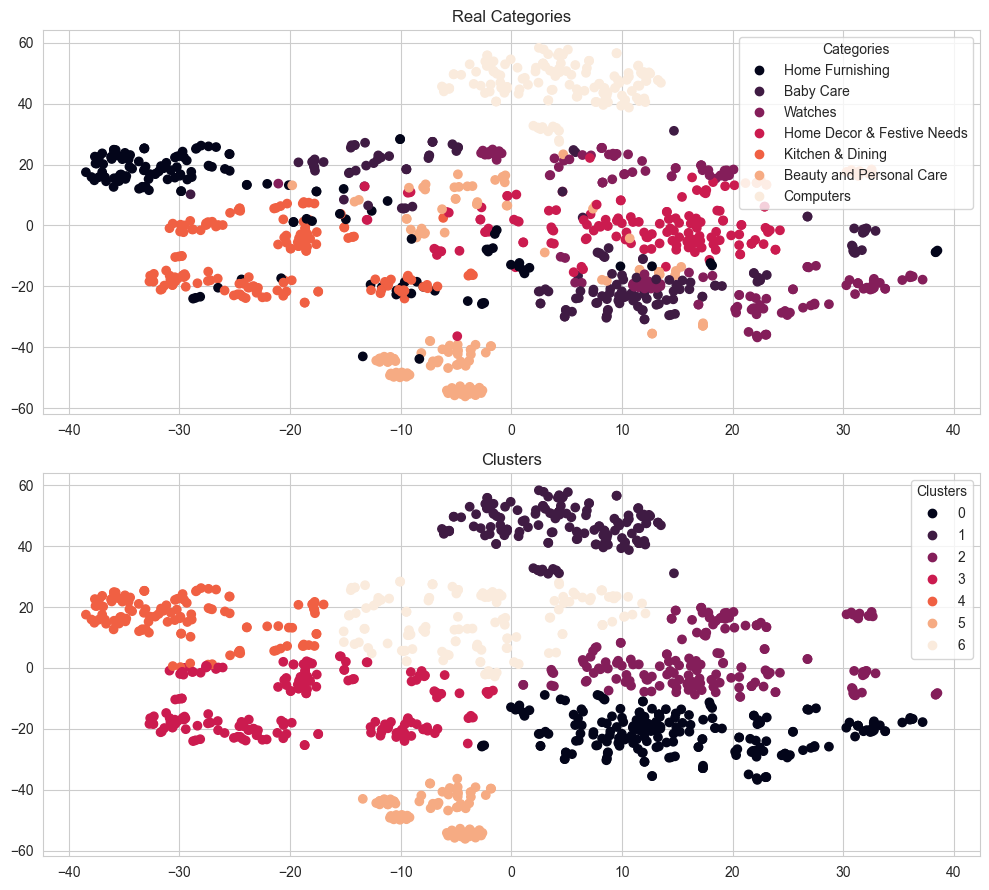

In [43]:
print("Méthode TD-IDF")
ARI, X_tsne, labels = ari_red(tf_vectorizer_transform)
plot_model(X_tsne, y_feature, labels)

### Méthode Word2Vec
Word2Vec est une technique populaire en traitement du langage naturel (NLP) permettant d'apprendre des représentations vectorielles (embeddings) de mots.
L'idée fondamentale derrière Word2Vec est de représenter les mots dans un espace vectoriel continu où les mots sémantiquement similaires sont proches les uns des autres.

In [45]:
tokenized_text = df2['clean_text'].apply(lambda x: x.split())
# entrainement model word2vec
model = Word2Vec(sentences=tokenized_text, vector_size=100, window=5, min_count=1, workers=4)
# transformation en representation de vectors
word2vec_transform = pd.DataFrame([model.wv[words].mean(axis=0) for words in tokenized_text])

Méthode Word2Vec
ARI :  0.17963836259046928 Temps d'exécution :  2.0


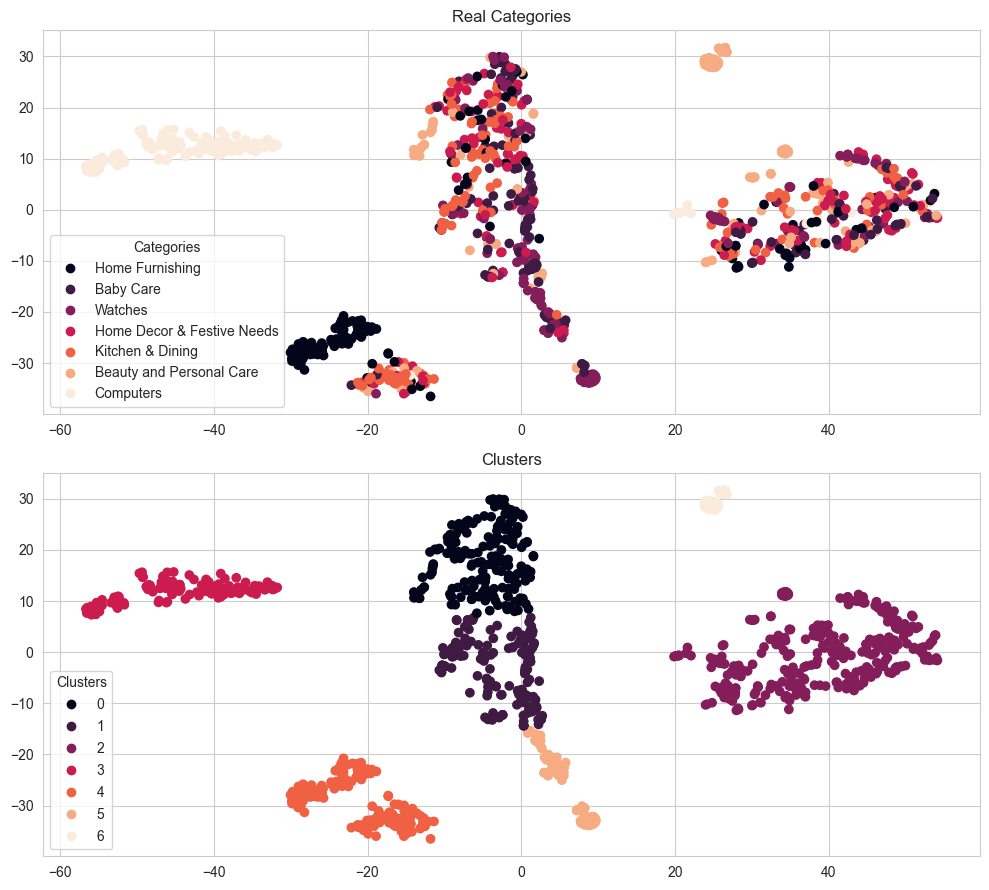

In [46]:
print("Méthode Word2Vec")
ARI, X_tsne, labels = ari_red(word2vec_transform)
plot_model(X_tsne, y_feature, labels)

Méthode Word2Vec
ARI :  0.1877992394179743 Temps d'exécution :  5.0


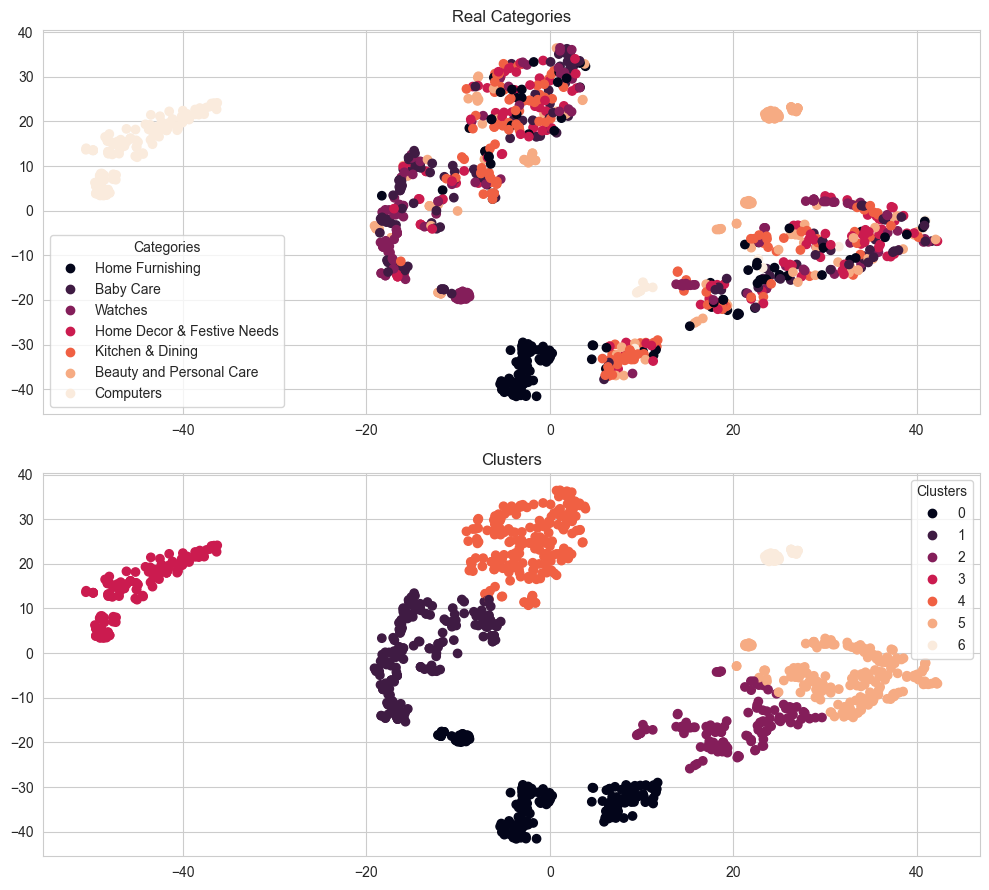

In [47]:
print("Méthode Word2Vec")
ARI, X_tsne, labels = ari_red_pca(word2vec_transform)
plot_model(X_tsne, y_feature, labels)

### Méthode BERT
BERT, acronyme de "Bidirectional Encoder Representations from Transformers", est un modèle de traitement du langage naturel (NLP) basé sur l'architecture des transformers.
L'une des caractéristiques principales de BERT est sa capacité à capturer la sémantique contextuelle des mots dans une phrase. 

In [48]:
text_column = df1['description'].tolist()
X_feature = extract_bert_features(text_column)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already

Temps d'exécution total : 149.31 secondes


ARI :  0.2589934019556603 Temps d'exécution :  6.0


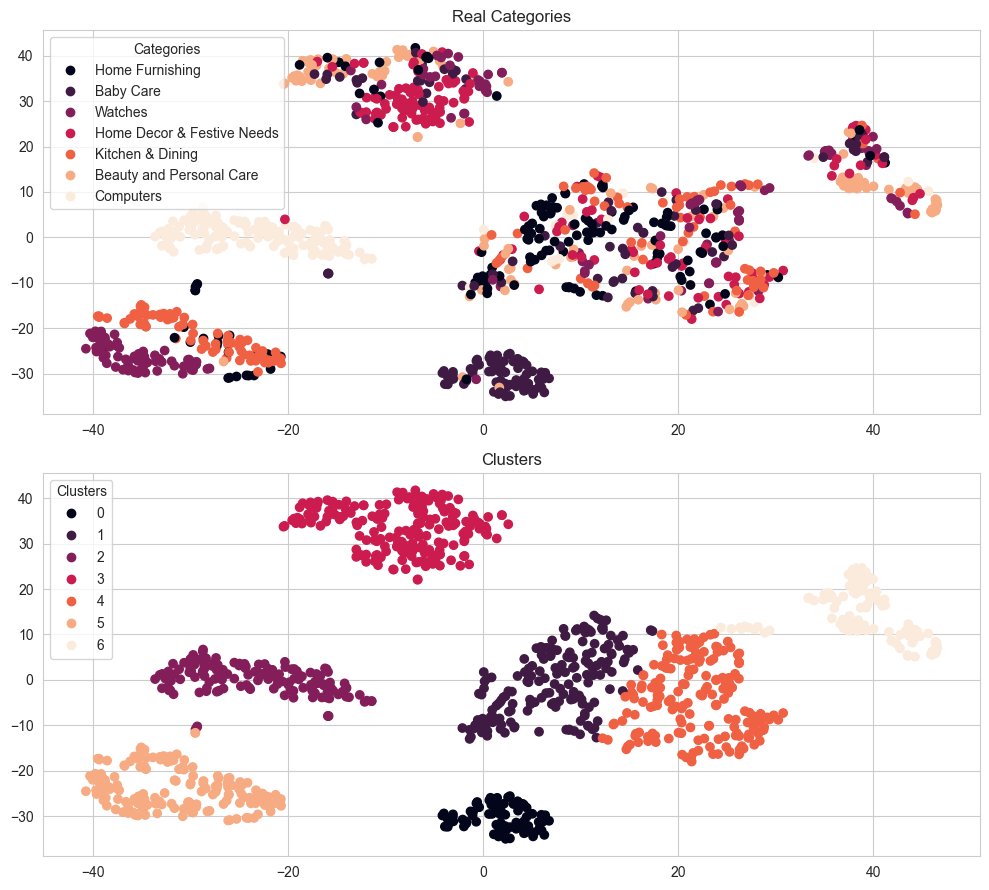

In [50]:
ARI, X_tsne, labels = ari_red_pca(X_feature)
plot_model(X_tsne, y_feature, labels)

### Méthode  USE
Le modèle Universal Sentence Encoder (USE) est un modèle de plongement de phrases développé par Google. 
Son objectif est de convertir des phrases complètes en vecteurs denses de nombres réels, appelés embeddings, tout en préservant la sémantique de la phrase.

In [51]:
# import du modèle USE
use_model = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

In [52]:
sentences = df1['description'].to_list()
batch_size = 10
features_USE = feature_USE_fct(sentences, batch_size)

Méthode USE
ARI :  0.4531172763659862 Temps d'exécution :  6.0


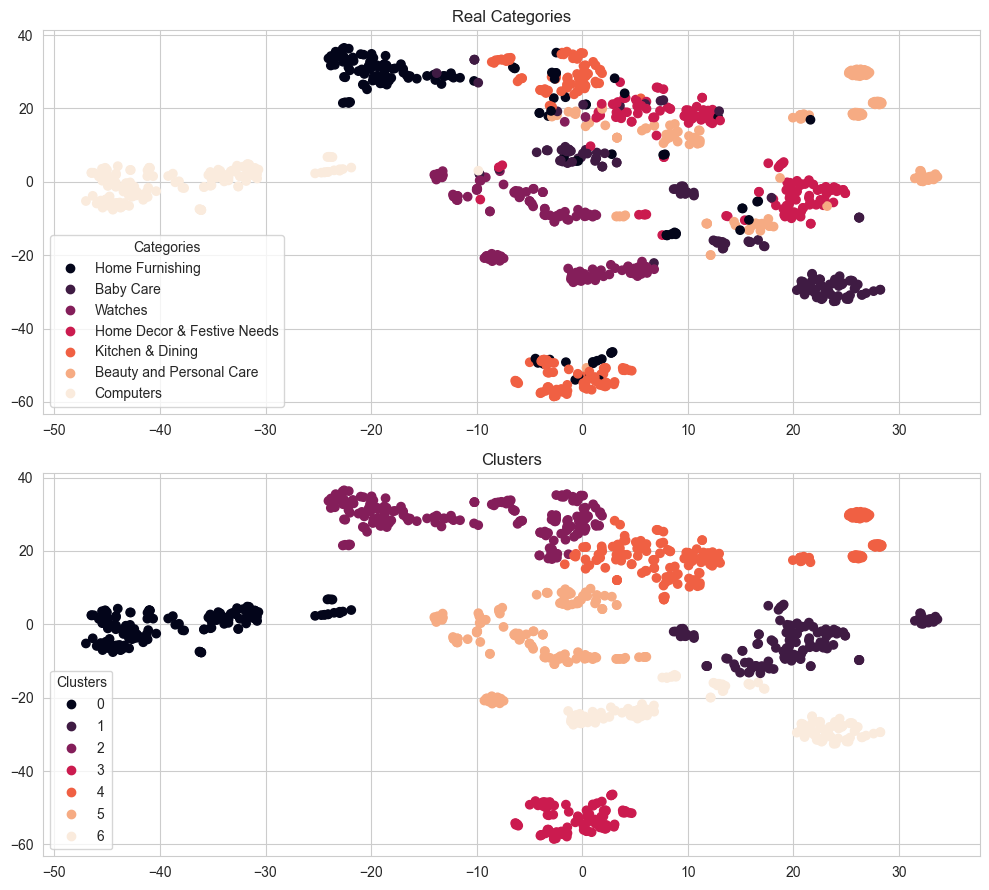

In [54]:
print('Méthode USE')
ARI, X_tsne, labels = ari_red_pca(features_USE)
plot_model(X_tsne, y_feature, labels)

### Traitement Images

In [55]:
# Import du jeu de données
data_image = df2[["image", "label_categ"]]
# path des données
path = "../data/raw/Images/"
data_image.loc[:, "image"] = data_image["image"].apply(lambda x: os.path.join(path, str(x)))
list_photos = [file for file in listdir(path)]
# contrôle images manquantes
images_manquantes = [img for img in data_image["image"] if not os.path.exists(img)]

In [56]:
data_image.to_csv("../data/processed/data_image.csv", index=False)

In [57]:
df2.to_csv("../data/processed/df2.csv", index=False)

In [58]:
# Afficher le nombre total d'images
print(f"Nombre total d'images : {len(data_image)}")
# Afficher le nombre d'images manquantes
print(f"Nombre d'images manquantes : {len(images_manquantes)}")

Nombre total d'images : 1050
Nombre d'images manquantes : 0


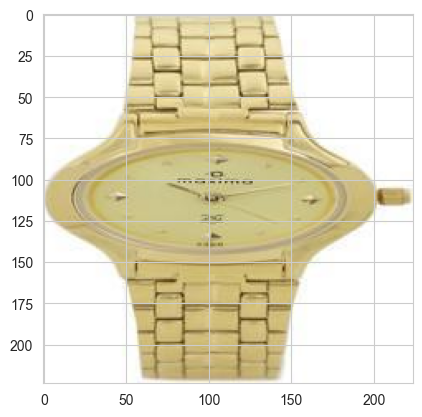

(<matplotlib.image.AxesImage at 0x35ea1ec10>, None)

In [59]:
# affichage image
plt.imshow(imread(path + list_photos[200])), plt.show()

### Test SIFT - ORB - SURF

In [60]:
import cv2

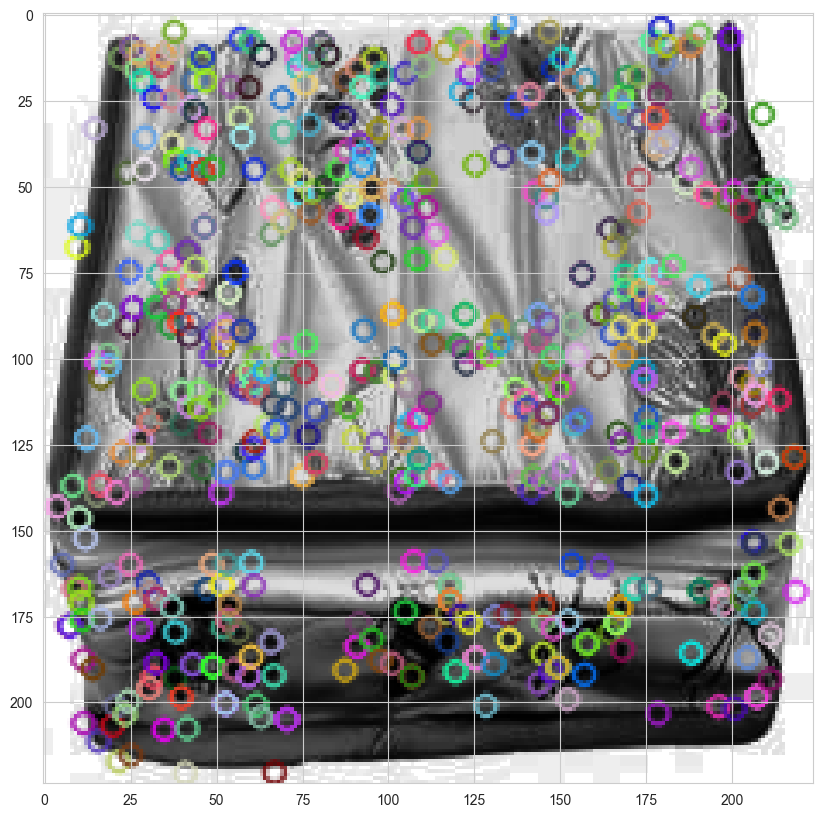

Le nombre des features extraits est de :  (593, 128)


In [61]:
# test méthode SIFT
test_img('sift',100)

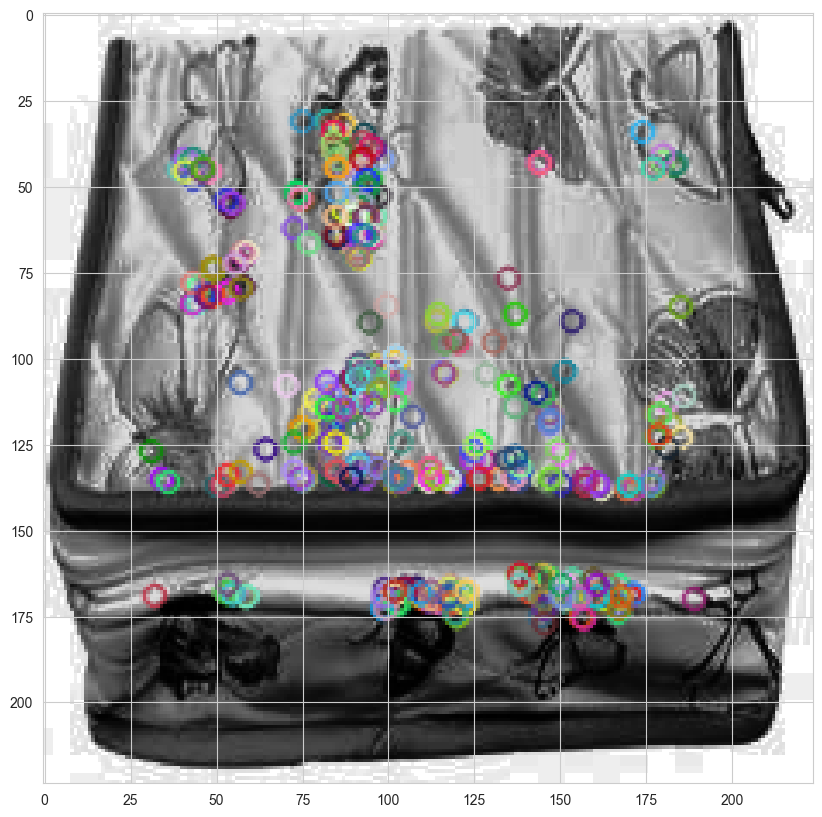

Le nombre des features extraits est de :  (410, 32)


In [62]:
# test méthode ORB
test_img('orb',100)

#### SIFT

In [63]:
# Utilisation du modèle du SIFT
sift_keypoints = []
temps1 = time.time()
sift = cv2.SIFT_create()

In [64]:
# boucle pour tous les images
for image_num in range(data_image.shape[0]):
    # Convertir en gris
    image = cv2.imread(data_image.image.iloc[image_num], 0)
    scale = 0.5  
    width = int(image.shape[1] * scale)
    height = int(image.shape[0] * scale)
    dim = (width, height)
    image = cv2.resize(image, dim, interpolation=cv2.INTER_AREA)
    # égaliser l'histogramme de l'image
    res = cv2.equalizeHist(image)
    del image
    # Ne récupérer que les descripteurs
    _, des = sift.detectAndCompute(res, None)  
    del res
    # Vérifier si descripteurs trouvés et non vides
    if des is not None and des.shape[0] > 0: 
        sift_keypoints.append(des)

In [65]:
# Filtrer les descripteurs
sift_keypoints_filtered = [des for des in sift_keypoints if des.shape[0] > 0]
# concatener les descripteurs
sift_keypoints_all = np.concatenate(sift_keypoints_filtered, axis=0)

In [66]:
print("Nombre de descripteurs : ", sift_keypoints_all.shape)
duration1=time.time()-temps1
print("Le délai de traitement pour le SIFT est de : ", "%15.2f" % duration1, "secondes")

# Sélection du nombre de clusters
temps2=time.time()
k = int(round(np.sqrt(len(sift_keypoints_all)),0))
print("Nombre de clusters estimés : ", k)
print("Création de",k, "clusters de descripteurs ...")

# Clustering
kmeans = cluster.MiniBatchKMeans(n_clusters = k, n_init=3, init_size = 3*k, random_state = 0)
kmeans.fit(sift_keypoints_all)
duration2=time.time()-temps2
print("Le délai de traitement pour le KMeans est de : ", "%15.2f" % duration2, "secondes")

Nombre de descripteurs :  (114722, 128)
Le délai de traitement pour le SIFT est de :             2.86 secondes
Nombre de clusters estimés :  339
Création de 339 clusters de descripteurs ...
Le délai de traitement pour le KMeans est de :             1.62 secondes


In [67]:
# Creation of histograms (features)
temps1=time.time()

def build_histogram(kmeans, des, image_num):
    res = kmeans.predict(des)
    hist = np.zeros(len(kmeans.cluster_centers_))
    nb_des=len(des)
    if nb_des==0 : print("problème histogramme image  : ", image_num)
    for i in res:
        hist[i] += 1.0/nb_des
    return hist


# Creation of a matrix of histograms
histo_vect=[]

for i, image_desc in enumerate(sift_keypoints_filtered) :
    if i%100 == 0 : print(i)
    hist = build_histogram(kmeans, image_desc, i) #calculates the histogram
    histo_vect.append(hist) #histogram is the feature vector

im_features = np.asarray(histo_vect)

duration1=time.time()-temps1
print("temps de création histogrammes : ", "%15.2f" % duration1, "secondes")

0
100
200
300
400
500
600
700
800
900
1000
temps de création histogrammes :             0.36 secondes


In [68]:
from sklearn.decomposition import PCA

In [69]:
print("Dimensions dataset avant réduction PCA : ", im_features.shape)

# Create a PCA instance with a specified variance to be preserved
pca = PCA(n_components=0.9)

# Fit and transform the dataset using PCA
feat_pca = pca.fit_transform(im_features)

print("Dimensions dataset après réduction PCA : ", feat_pca.shape)

Dimensions dataset avant réduction PCA :  (1050, 339)
Dimensions dataset après réduction PCA :  (1050, 195)


In [70]:
tsne = manifold.TSNE(n_components=2, learning_rate=200, init='random', random_state=100)
X_tsne_sift = tsne.fit_transform(feat_pca)

df_tsne = pd.DataFrame(X_tsne[:,0:2], columns=['tsne1', 'tsne2'])
df_tsne["class"] = data_image["label_categ"]
print(df_tsne.shape)

(1050, 3)


ARI :  0.02754513474539411 Temps d'exécution :  2.0


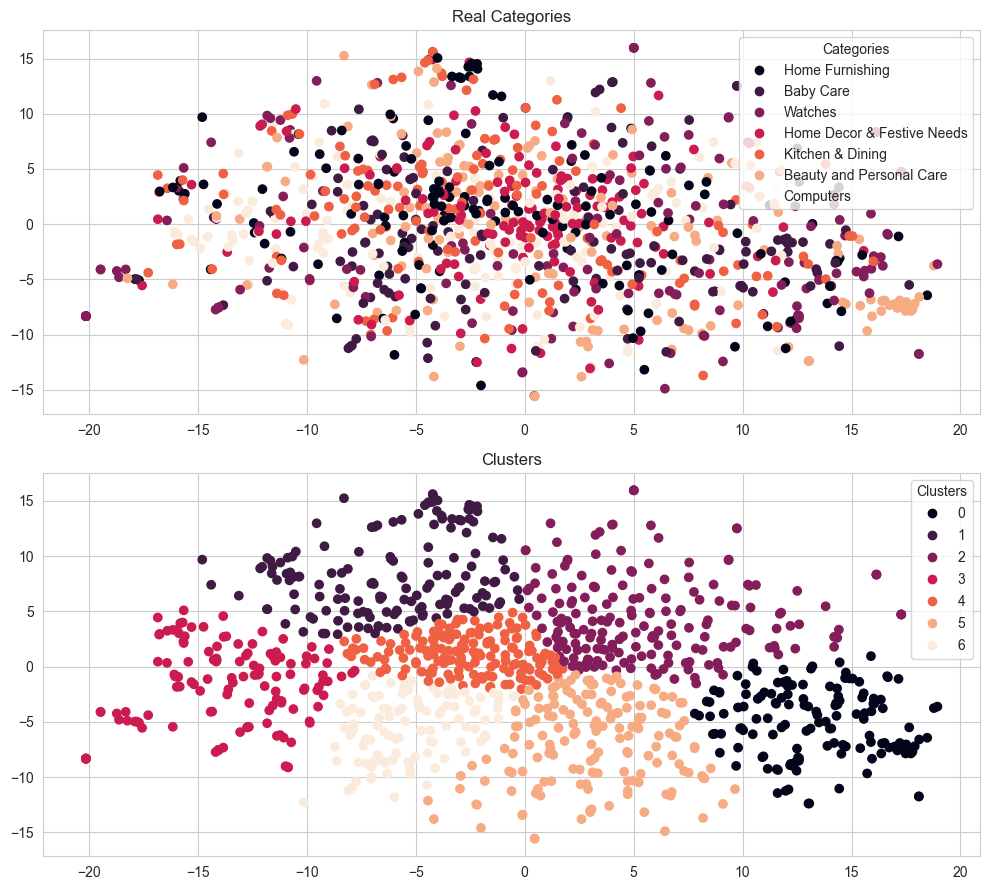

In [71]:
# Visualisation des clusters
ARI, X_tsne, labels = ari_red(X_tsne_sift)
plot_model(X_tsne_sift, y_feature, labels)

### Transfert Learning

In [72]:
from keras.applications.vgg19 import VGG19, preprocess_input
from keras.models import Model
from keras.preprocessing.image import load_img, img_to_array
import pandas as pd

In [73]:
# init VGG19
model = VGG19()
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)

vecteur = []
for num_image in range(data_image.shape[0]):
    # Chargemet image fichier
    image = load_img(data_image.image.iloc[num_image], target_size=(224, 224))
    # Conversion des pixels de l'image en un tableau numpy
    image = img_to_array(image)
    # Remodelisation des données pour le modèle
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # Prépararation de l'image pour le modèle VGG
    image = preprocess_input(image)

    # caractéristiques extraites
    caractéristiques = model.predict(image)
    print(caractéristiques.shape)
    vecteur.append(caractéristiques[0])

im_caract_cnn = pd.DataFrame(vecteur)

1/1 [==============================] - 1s 541ms/step
(1, 4096)
1/1 [==============================] - 0s 151ms/step
(1, 4096)
1/1 [==============================] - 0s 148ms/step
(1, 4096)
1/1 [==============================] - 0s 160ms/step
(1, 4096)
1/1 [==============================] - 0s 152ms/step
(1, 4096)
1/1 [==============================] - 0s 153ms/step
(1, 4096)
1/1 [==============================] - 0s 159ms/step
(1, 4096)
1/1 [==============================] - 0s 150ms/step
(1, 4096)
1/1 [==============================] - 0s 152ms/step
(1, 4096)
1/1 [==============================] - 0s 154ms/step
(1, 4096)
1/1 [==============================] - 0s 153ms/step
(1, 4096)
1/1 [==============================] - 0s 148ms/step
(1, 4096)
1/1 [==============================] - 0s 152ms/step
(1, 4096)
1/1 [==============================] - 0s 152ms/step
(1, 4096)
1/1 [==============================] - 0s 143ms/step
(1, 4096)
1/1 [==============================] - 0s 154ms/step
(1

In [74]:
print("Dimensions dataset avant réduction PCA : ", im_caract_cnn.shape)
# init PCA
pca = PCA(n_components=0.9)
# Fit and transform df avec PCA
feat_pca_cnn = pca.fit_transform(im_caract_cnn)
print("Dimensions dataset après réduction PCA : ", feat_pca_cnn.shape)

Dimensions dataset avant réduction PCA :  (1050, 4096)
Dimensions dataset après réduction PCA :  (1050, 297)


ARI :  0.5523022007630232 Temps d'exécution :  2.0


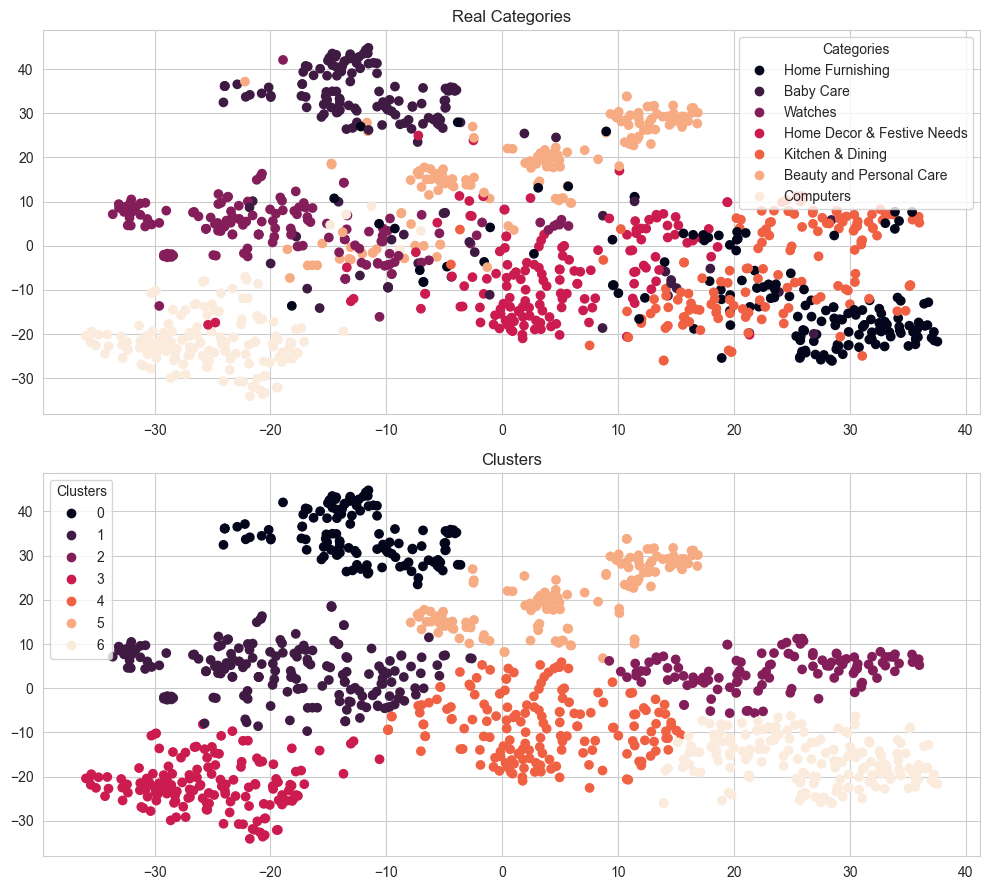

In [75]:
ARI_cnn, X_tsne_cnn, labels_cnn = ari_red(feat_pca_cnn)
plot_model(X_tsne_cnn, y_feature, labels_cnn)